In [4]:
#activations.py

"""
Author: Sophia Sanborn
Institution: UC Berkeley
Date: Spring 2020
Course: CS189/289A
Website: github.com/sophiaas
"""

import numpy as np
from abc import ABC, abstractmethod


class Activation(ABC):
    """Abstract class defining the common interface for all activation methods."""

    def __call__(self, Z):
        return self.forward(Z)

    @abstractmethod
    def forward(self, Z):
        pass


def initialize_activation(name: str) -> Activation:
    """Factory method to return an Activation object of the specified type."""
    if name == "linear":
        return Linear()
    elif name == "sigmoid":
        return Sigmoid()
    elif name == "tanh":
        return TanH()
    elif name == "arctan":
        return ArcTan()
    elif name == "relu":
        return ReLU()
    elif name == "softmax":
        return SoftMax()
    else:
        raise NotImplementedError("{} activation is not implemented".format(name))


class Linear(Activation):
    def __init__(self):
        super().__init__()

    def forward(self, Z: np.ndarray) -> np.ndarray:
        """Forward pass for f(z) = z.
        
        Parameters
        ----------
        Z  input pre-activations (any shape)

        Returns
        -------
        f(z) as described above applied elementwise to `Z`
        """
        return Z

    def backward(self, Z: np.ndarray, dY: np.ndarray) -> np.ndarray:
        """Backward pass for f(z) = z.
        
        Parameters
        ----------
        Z   input to `forward` method
        dY  derivative of loss w.r.t. the output of this layer
            same shape as `Z`

        Returns
        -------
        derivative of loss w.r.t. input of this layer
        """
        return dY


class Sigmoid(Activation):
    def __init__(self):
        super().__init__()

    def forward(self, Z: np.ndarray) -> np.ndarray:
        """Forward pass for sigmoid function:
        f(z) = 1 / (1 + exp(-z))
        
        Parameters
        ----------
        Z  input pre-activations (any shape)

        Returns
        -------
        f(z) as described above applied elementwise to `Z`
        """
        ### YOUR CODE HERE ###
        return ...

    def backward(self, Z: np.ndarray, dY: np.ndarray) -> np.ndarray:
        """Backward pass for sigmoid.
        
        Parameters
        ----------
        Z   input to `forward` method
        dY  derivative of loss w.r.t. the output of this layer
            same shape as `Z`

        Returns
        -------
        derivative of loss w.r.t. input of this layer
        """
        ### YOUR CODE HERE ###
        return ...


class TanH(Activation):
    def __init__(self):
        super().__init__()

    def forward(self, Z: np.ndarray) -> np.ndarray:
        """Forward pass for f(z) = tanh(z).
        
        Parameters
        ----------
        Z  input pre-activations (any shape)

        Returns
        -------
        f(z) as described above applied elementwise to `Z`
        """
        return 2 / (1 + np.exp(-2 * Z)) - 1

    def backward(self, Z: np.ndarray, dY: np.ndarray) -> np.ndarray:
        """Backward pass for f(z) = tanh(z).
        
        Parameters
        ----------
        Z   input to `forward` method
        dY  derivative of loss w.r.t. the output of this layer

        Returns
        -------
        derivative of loss w.r.t. input of this layer
        """
        fn = self.forward(Z)
        return dY * (1 - fn ** 2)


class ReLU(Activation):
    def __init__(self):
        super().__init__()

    def forward(self, Z: np.ndarray) -> np.ndarray:
        """Forward pass for relu activation:
        f(z) = z if z >= 0
               0 otherwise
        
        Parameters
        ----------
        Z  input pre-activations (any shape)

        Returns
        -------
        f(z) as described above applied elementwise to `Z`
        """
        ### YOUR CODE HERE ###
        out = np.maximum(0, Z)
        return out

    def backward(self, Z: np.ndarray, dY: np.ndarray) -> np.ndarray:
        """Backward pass for relu activation.
        
        Parameters
        ----------
        Z   input to `forward` method
        dY  derivative of loss w.r.t. the output of this layer
            same shape as `Z`

        Returns
        -------
        derivative of loss w.r.t. input of this layer
        """
        ### YOUR CODE HERE ###
        return dY * np.where(Z > 0, 1, 0)


class SoftMax(Activation):
    def __init__(self):
        super().__init__()

    def forward(self, Z: np.ndarray) -> np.ndarray:
        """Forward pass for softmax activation.
        Hint: The naive implementation might not be numerically stable.
        
        Parameters
        ----------
        Z  input pre-activations (any shape)

        Returns
        -------
        f(z) as described above applied elementwise to `Z`
        """
        ### YOUR CODE HERE ###
        m = np.max(Z, axis=1).reshape(-1, 1)
        sm = Z - m
        
        exp_sm = np.exp(sm)
        
        return exp_sm / np.sum(exp_sm, axis=1).reshape(-1, 1)

    def backward(self, Z: np.ndarray, dY: np.ndarray) -> np.ndarray:
        """Backward pass for softmax activation.
        
        Parameters
        ----------
        Z   input to `forward` method
        dY  derivative of loss w.r.t. the output of this layer
            same shape as `Z`

        Returns
        -------
        derivative of loss w.r.t. input of this layer
        """
        ### YOUR CODE HERE ###
        dLdZ = np.zeros(Z.shape)
        softmaxZ = self.forward(Z)
        
        for i in range(0, softmaxZ.shape[0]):
            curr_sample = softmaxZ[i, :][:, None]
            curr_dY = dY[i, :][:, None]
            j = np.matmul(-curr_sample, curr_sample.T)
            
            np.fill_diagonal(j, np.array([s*(1-s) for s in curr_sample]))
            dLdZ[i, :][:, None] = np.matmul(j, curr_dY)
        
        return dLdZ


class ArcTan(Activation):
    def __init__(self):
        super().__init__()

    def forward(self, Z):
        return np.arctan(Z)

    def backward(self, Z, dY):
        return dY * 1 / (Z ** 2 + 1)


## Layers.py

In [6]:
"""
Author: Sophia Sanborn, Sagnik Bhattacharya
Institution: UC Berkeley
Date: Spring 2020
Course: CS189/289A
Website: github.com/sophiaas, github.com/sagnibak
"""

import numpy as np
from abc import ABC, abstractmethod

from neural_networks.activations import initialize_activation
from neural_networks.weights import initialize_weights
from collections import OrderedDict
from neural_networks.utils.convolution import pad2d

from typing import Callable, List, Literal, Tuple, Union


class Layer(ABC):
    """Abstract class defining the `Layer` interface."""

    def __init__(self):
        self.activation = None

        self.n_in = None
        self.n_out = None

        self.parameters = {}
        self.cache = {}
        self.gradients = {}

        super().__init__()

    @abstractmethod
    def forward(self, z: np.ndarray) -> np.ndarray:
        pass

    def clear_gradients(self) -> None:
        self.cache = OrderedDict({a: [] for a, b in self.cache.items()})
        self.gradients = OrderedDict(
            {a: np.zeros_like(b) for a, b in self.gradients.items()}
        )

    def forward_with_param(
        self, param_name: str, X: np.ndarray,
    ) -> Callable[[np.ndarray], np.ndarray]:
        """Call the `forward` method but with `param_name` as the variable with
        value `param_val`, and keep `X` fixed.
        """

        def inner_forward(param_val: np.ndarray) -> np.ndarray:
            self.parameters[param_name] = param_val
            return self.forward(X)

        return inner_forward

    def _get_parameters(self) -> List[np.ndarray]:
        return [b for a, b in self.parameters.items()]

    def _get_cache(self) -> List[np.ndarray]:
        return [b for a, b in self.cache.items()]

    def _get_gradients(self) -> List[np.ndarray]:
        return [b for a, b in self.gradients.items()]


def initialize_layer(
    name: str,
    activation: str = None,
    weight_init: str = None,
    n_out: int = None,
    kernel_shape: Tuple[int, int] = None,
    stride: int = None,
    pad: int = None,
    mode: str = None,
    keep_dim: str = "first",
) -> Layer:
    """Factory function for layers."""
    if name == "fully_connected":
        return FullyConnected(
            n_out=n_out, activation=activation, weight_init=weight_init,
        )

    elif name == "conv2d":
        return Conv2D(
            n_out=n_out,
            activation=activation,
            kernel_shape=kernel_shape,
            stride=stride,
            pad=pad,
            weight_init=weight_init,
        )

    elif name == "pool2d":
        return Pool2D(kernel_shape=kernel_shape, mode=mode, stride=stride, pad=pad)

    elif name == "flatten":
        return Flatten(keep_dim=keep_dim)

    else:
        raise NotImplementedError("Layer type {} is not implemented".format(name))



class FullyConnected(Layer):
    """A fully-connected layer multiplies its input by a weight matrix, adds
    a bias, and then applies an activation function.
    """

    def __init__(
        self, n_out: int, activation: str, weight_init="xavier_uniform"
    ) -> None:

        super().__init__()
        self.n_in = None
        self.n_out = n_out
        self.activation = initialize_activation(activation)

        # instantiate the weight initializer
        self.init_weights = initialize_weights(weight_init, activation=activation)

    def _init_parameters(self, X_shape: Tuple[int, int]) -> None:
        """Initialize all layer parameters (weights, biases)."""
        self.n_in = X_shape[1]

        ### BEGIN YOUR CODE ###

        W = self.init_weights((self.n_in, self.n_out))
        b = np.zeros((1, self.n_out))

        self.parameters = OrderedDict({"W": W, "b": b})
        self.cache: OrderedDict = {}  # cache for backprop
        self.gradients: OrderedDict = OrderedDict({"W": np.zeros(W.shape), "b": np.zeros(b.shape)})
            # parameter gradients initialized to zero
            # MUST HAVE THE SAME KEYS AS `self.parameters`
 
        ### END YOUR CODE ###

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass: multiply by a weight matrix, add a bias, apply activation.
        Also, store all necessary intermediate results in the `cache` dictionary
        to be able to compute the backward pass.

        Parameters
        ----------
        X  input matrix of shape (batch_size, input_dim)

        Returns
        -------
        a matrix of shape (batch_size, output_dim)
        """
        # initialize layer parameters if they have not been initialized
        if self.n_in is None:
            self._init_parameters(X.shape)

        ### BEGIN YOUR CODE ###
        
        # perform an affine transformation and activation
        Z = np.matmul(X, self.parameters["W"]) + self.parameters["b"]
        out = self.activation(Z)
        
        # store information necessary for backprop in `self.cache`
        self.cache = {"X": X, "Z": Z}

        ### END YOUR CODE ###

        return out

    def backward(self, dLdY: np.ndarray) -> np.ndarray:
        """Backward pass for fully connected layer.
        Compute the gradients of the loss with respect to:
            1. the weights of this layer (mutate the `gradients` dictionary)
            2. the bias of this layer (mutate the `gradients` dictionary)
            3. the input of this layer (return this)

        Parameters
        ----------
        dLdY  derivative of the loss with respect to the output of this layer
              shape (batch_size, output_dim)

        Returns
        -------
        derivative of the loss with respect to the input of this layer
        shape (batch_size, input_dim)
        """
        ### BEGIN YOUR CODE ###
       
        # unpack the cache
        X= self.cache["X"]
        Z = self.cache["Z"]
        batch_size = X.shape[0]
        
        # compute the gradients of the loss w.r.t. all parameters as well as the
        # input of the layer
        
        dLdZ = self.activation.backward(Z, dLdY)
        dLdW = np.matmul(X.T, dLdZ)
        dLdb = np.matmul(dLdZ.T, np.ones((batch_size, 1))).reshape(self.n_out,)
        dX = np.matmul(dLdZ, self.parameters["W"].T)

        # store the gradients in `self.gradients`
        # the gradient for self.parameters["W"] should be stored in
        # self.gradients["W"], etc.
        self.gradients = {
            "W": dLdW,
            "b": dLdb
        }
        ### END YOUR CODE ###

        return dX


class Conv2D(Layer):
    """Convolutional layer for inputs with 2 spatial dimensions."""

    def __init__(
        self,
        n_out: int,
        kernel_shape: Tuple[int, int],
        activation: str,
        stride: int = 1,
        pad: str = "same",
        weight_init: str = "xavier_uniform",
    ) -> None:

        super().__init__()
        self.n_in = None
        self.n_out = n_out
        self.kernel_shape = kernel_shape
        self.stride = stride
        self.pad = pad

        self.activation = initialize_activation(activation)
        self.init_weights = initialize_weights(weight_init, activation=activation)

    def _init_parameters(self, X_shape: Tuple[int, int, int, int]) -> None:
        """Initialize all layer parameters and determine padding."""
        self.n_in = X_shape[3]

        W_shape = self.kernel_shape + (self.n_in,) + (self.n_out,)
        W = self.init_weights(W_shape)
        b = np.zeros((1, self.n_out))

        self.parameters = OrderedDict({"W": W, "b": b})
        self.cache = OrderedDict({"Z": [], "X": []})
        self.gradients = OrderedDict({"W": np.zeros_like(W), "b": np.zeros_like(b)})

        if self.pad == "same":
            self.pad = ((W_shape[0] - 1) // 2, (W_shape[1] - 1) // 2)
        elif self.pad == "valid":
            self.pad = (0, 0)
        elif isinstance(self.pad, int):
            self.pad = (self.pad, self.pad)
        else:
            raise ValueError("Invalid Pad mode found in self.pad.")

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass for convolutional layer. This layer convolves the input
        `X` with a filter of weights, adds a bias term, and applies an activation
        function to compute the output. This layer also supports padding and
        integer strides. Intermediates necessary for the backward pass are stored
        in the cache.

        Parameters
        ----------
        X  input with shape (batch_size, in_rows, in_cols, in_channels)

        Returns
        -------
        output feature maps with shape (batch_size, out_rows, out_cols, out_channels)
        """
        if self.n_in is None:
            self._init_parameters(X.shape)

        W = self.parameters["W"]
        b = self.parameters["b"]

        kernel_height, kernel_width, in_channels, out_channels = W.shape
        n_examples, in_rows, in_cols, in_channels = X.shape
        kernel_shape = (kernel_height, kernel_width)

        ### BEGIN YOUR CODE ###
        padded_x, p = pad2d(X, self.pad, kernel_shape, stride=self.stride)
        _, padH, padW, _ = p

        # implement a convolutional forward pass
        Hout = int(1 + (in_rows + 2*padH - kernel_height) / self.stride)
        Wout = int(1 + (in_cols + 2*padW - kernel_width) / self.stride)
        Z = np.empty((n_examples,Hout,Wout,out_channels))
        
        for h in range(Hout):
            for wi in range(Wout):
                toConvolute = padded_x[:, h*self.stride : h*self.stride+kernel_height, wi*self.stride : wi*self.stride+kernel_width, :]
                for f in range(out_channels):
                    Z[:, h, wi, f] = np.sum(toConvolute*W[:, :, :, f], axis=(1,2,3)) + b[0, f]
                    
        out = self.activation(Z)

        # cache any values required for backprop
        self.cache["X"] = X
        self.cache["Z"] = Z
        ### END YOUR CODE ###

        return out
    
    

    def backward(self, dLdY: np.ndarray) -> np.ndarray:
        """Backward pass for conv layer. Computes the gradients of the output
        with respect to the input feature maps as well as the filter weights and
        biases.

        Parameters
        ----------
        dLdY  derivative of loss with respect to output of this layer
              shape (batch_size, out_rows, out_cols, out_channels)

        Returns
        -------
        derivative of the loss with respect to the input of this layer
        shape (batch_size, in_rows, in_cols, in_channels)
        """
        ### BEGIN YOUR CODE ###
        
        
        X = self.cache["X"]
        Z = self.cache["Z"]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        kernel_height, kernel_width, in_channels, out_channels = W.shape
        n_examples, in_rows, in_cols, in_channels = X.shape
        kernel_shape = (kernel_height, kernel_width)
                
                
        Hout = dLdY.shape[1]
        Wout = dLdY.shape[2]
        
        padded_x, p = pad2d(X, self.pad, kernel_shape, stride=self.stride)
        _, padH, padW, _ = p

        padded_dx = np.zeros(padded_x.shape)
        dw = np.zeros(W.shape)    
        
        # perform a backward pass
        
        dLdY = self.activation.backward(Z, dLdY)
        
        for i in range(Hout):
            for j in range(Wout):
                h_start = i* self.stride
                h_end = h_start +kernel_height
                w_start = j *self.stride
                w_end = w_start + kernel_width
                padded_dx [:, h_start:h_end, w_start:w_end, :] +=\
                    (W[np.newaxis, :, :, :, :]*dLdY[:, i:i+1, j:j+1, np.newaxis, :]).sum(axis=4)
                dw += np.sum(padded_x[:, h_start:h_end, w_start:w_end, :, np.newaxis] *\
                             dLdY[:, i:i+1, j:j+1, np.newaxis, :], axis=0)
                    
        dx = padded_dx[:,padH:-padH, padW:-padW, :]
        db = dLdY.sum(axis=(0, 1, 2)).reshape(1, -1)
        
        #storing gradients
        self.gradients["W"] = dw
        self.gradients["b"] = db

        ### END YOUR CODE ###

        return dx
    
        

class Pool2D(Layer):
    """Pooling layer, implements max and average pooling."""

    def __init__(
        self,
        kernel_shape: Tuple[int, int],
        mode: str = "max",
        stride: int = 1,
        pad: Union[int, Literal["same"], Literal["valid"]] = 0,
    ) -> None:

        if type(kernel_shape) == int:
            kernel_shape = (kernel_shape, kernel_shape)

        self.kernel_shape = kernel_shape
        self.stride = stride

        if pad == "same":
            self.pad = ((kernel_shape[0] - 1) // 2, (kernel_shape[1] - 1) // 2)
        elif pad == "valid":
            self.pad = (0, 0)
        elif isinstance(pad, int):
            self.pad = (pad, pad)
        else:
            raise ValueError("Invalid Pad mode found in self.pad.")

        self.mode = mode

        if mode == "max":
            self.pool_fn = np.max
            self.arg_pool_fn = np.argmax
        elif mode == "average":
            self.pool_fn = np.mean

        self.cache = {
            "out_rows": [],
            "out_cols": [],
            "X_pad": [],
            "p": [],
            "pool_shape": [],
        }
        self.parameters = {}
        self.gradients = {}

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass: use the pooling function to aggregate local information
        in the input. This layer typically reduces the spatial dimensionality of
        the input while keeping the number of feature maps the same.

        As with all other layers, please make sure to cache the appropriate
        information for the backward pass.

        Parameters
        ----------
        X  input array of shape (batch_size, in_rows, in_cols, channels)

        Returns
        -------
        pooled array of shape (batch_size, out_rows, out_cols, channels)
        """
        ### BEGIN YOUR CODE ###

        # implement the forward pass

        # cache any values required for backprop

        ### END YOUR CODE ###
        
    
        n, h_in, w_in, c = X.shape
        pad_h, pad_w = self.pad
        h_pool, w_pool = self.kernel_shape
        h_pads = h_pool- 2*pad_h
        w_pads= w_pool - 2*pad_w
        h_out = 1 + (h_in - h_pads) // self.stride
        w_out = 1 + (w_in - w_pads) // self.stride
        output = np.zeros((n, h_out, w_out, c))

        for i in range(h_out):
            for j in range(w_out):
                h_start = i * self.stride
                h_end = h_start + h_pads
                w_start = j * self.stride
                w_end = w_start + w_pads
                a_prev_slice = X[:, h_start:h_end, w_start:w_end, :]
                #self._save_mask(x=a_prev_slice, cords=(i, j))
                output[:, i, j, :] = self.pool_fn(a_prev_slice, axis=(1, 2))
        return output


    def backward(self, dLdY: np.ndarray) -> np.ndarray:
        """Backward pass for pooling layer.

        Parameters
        ----------
        dLdY  gradient of loss with respect to the output of this layer
              shape (batch_size, out_rows, out_cols, channels)

        Returns
        -------
        gradient of loss with respect to the input of this layer
        shape (batch_size, in_rows, in_cols, channels)
        """
        ### BEGIN YOUR CODE ###

        # perform a backward pass

        ### END YOUR CODE ###

        return dX

class Flatten(Layer):
    """Flatten the input array."""

    def __init__(self, keep_dim: str = "first") -> None:
        super().__init__()

        self.keep_dim = keep_dim
        self._init_params()

    def _init_params(self):
        self.X = []
        self.gradients = {}
        self.parameters = {}
        self.cache = {"in_dims": []}

    def forward(self, X: np.ndarray, retain_derived: bool = True) -> np.ndarray:
        self.cache["in_dims"] = X.shape

        if self.keep_dim == -1:
            return X.flatten().reshape(1, -1)

        rs = (X.shape[0], -1) if self.keep_dim == "first" else (-1, X.shape[-1])
        return X.reshape(*rs)

    def backward(self, dLdY: np.ndarray) -> np.ndarray:
        in_dims = self.cache["in_dims"]
        dX = dLdY.reshape(in_dims)
        return dX


### Losses.py

In [ ]:
"""
Author: Sophia Sanborn
Institution: UC Berkeley
Date: Spring 2020
Course: CS189/289A
Website: github.com/sophiaas
"""

import numpy as np
from abc import ABC, abstractmethod


class Loss(ABC):
    @abstractmethod
    def forward(self):
        pass

    @abstractmethod
    def backward(self):
        pass


def initialize_loss(name: str) -> Loss:
    if name == "cross_entropy":
        return CrossEntropy(name)
    elif name == "l2":
        return L2(name)
    else:
        raise NotImplementedError("{} loss is not implemented".format(name))


class CrossEntropy(Loss):
    """Cross entropy loss function."""

    def __init__(self, name: str) -> None:
        self.name = name

    def __call__(self, Y: np.ndarray, Y_hat: np.ndarray) -> float:
        return self.forward(Y, Y_hat)

    def forward(self, Y: np.ndarray, Y_hat: np.ndarray) -> float:
        """Computes the loss for predictions `Y_hat` given one-hot encoded labels
        `Y`.

        Parameters
        ----------
        Y      one-hot encoded labels of shape (batch_size, num_classes)
        Y_hat  model predictions in range (0, 1) of shape (batch_size, num_classes)

        Returns
        -------
        a single float representing the loss
        """
        ### YOUR CODE HERE ###
        m = Y.shape[0]
        loss = np.sum( np.diag( np.matmul( Y, np.log(Y_hat + 1e-10).T) ) )
        
        
        return (-1/m)*loss

    def backward(self, Y: np.ndarray, Y_hat: np.ndarray) -> np.ndarray:
        """Backward pass of cross-entropy loss.
        NOTE: This is correct ONLY when the loss function is SoftMax.

        Parameters
        ----------
        Y      one-hot encoded labels of shape (batch_size, num_classes)
        Y_hat  model predictions in range (0, 1) of shape (batch_size, num_classes)

        Returns
        -------
        the derivative of the cross-entropy loss with respect to the vector of
        predictions, `Y_hat`
        """
        ### YOUR CODE HERE ###
        m = Y.shape[0]
        return (-1/m)*Y/(Y_hat+1e-11)


class L2(Loss):
    """Mean squared error loss."""

    def __init__(self, name: str) -> None:
        self.name = name

    def __call__(self, Y: np.ndarray, Y_hat: np.ndarray) -> float:
        return self.forward(Y, Y_hat)

    def forward(self, Y: np.ndarray, Y_hat: np.ndarray) -> float:
        """Compute the mean squared error loss for predictions `Y_hat` given
        regression targets `Y`.

        Parameters
        ----------
        Y      vector of regression targets of shape (batch_size, 1)
        Y_hat  vector of predictions of shape (batch_size, 1)

        Returns
        -------
        a single float representing the loss
        """
        ### YOUR CODE HERE ###
        return ...

    def backward(self, Y: np.ndarray, Y_hat: np.ndarray) -> np.ndarray:
        """Backward pass for mean squared error loss.

        Parameters
        ----------
        Y      vector of regression targets of shape (batch_size, 1)
        Y_hat  vector of predictions of shape (batch_size, 1)

        Returns
        -------
        the derivative of the mean squared error with respect to the last layer
        of the neural network
        """
        ### YOUR CODE HERE ###
        return ...



### models.py

In [ ]:
"""
Author: Sophia Sanborn
Institution: UC Berkeley
Date: Spring 2020
Course: CS189/289A
Website: github.com/sophiaas
"""

from abc import ABC, abstractmethod
import numpy as np

from neural_networks.losses import initialize_loss
from neural_networks.optimizers import initialize_optimizer
from neural_networks.layers import initialize_layer
from collections import OrderedDict
import pickle
from tqdm import tqdm
import pandas as pd

# imports for typing only
from neural_networks.utils.data_structures import AttrDict
from neural_networks.datasets import Dataset
from typing import Any, Dict, List, Sequence, Tuple


def initialize_model(name, loss, layer_args, optimizer_args, logger=None, seed=None):

    return NeuralNetwork(
        loss=loss,
        layer_args=layer_args,
        optimizer_args=optimizer_args,
        logger=logger,
        seed=seed,
    )


class NeuralNetwork(ABC):
    def __init__(
        self,
        loss: str,
        layer_args: Sequence[AttrDict],
        optimizer_args: AttrDict,
        logger=None,
        seed: int = None,
    ) -> None:

        self.n_layers = len(layer_args)
        self.layer_args = layer_args
        self.logger = logger
        self.epoch_log = {"loss": {}, "error": {}}

        self.loss = initialize_loss(loss)
        self.optimizer = initialize_optimizer(**optimizer_args)
        self._initialize_layers(layer_args)

    def _initialize_layers(self, layer_args: Sequence[AttrDict]) -> None:
        self.layers = []
        for l_arg in layer_args[:-1]:
            l = initialize_layer(**l_arg)
            self.layers.append(l)

    def _log(self, loss: float, error: float, validation: bool = False) -> None:

        if self.logger is not None:
            if validation:

                self.epoch_log["loss"]["validate"] = round(loss, 4)
                self.epoch_log["error"]["validate"] = round(error, 4)
                self.logger.push(self.epoch_log)
                self.epoch_log = {"loss": {}, "error": {}}
            else:
                self.epoch_log["loss"]["train"] = round(loss, 4)
                self.epoch_log["error"]["train"] = round(error, 4)

    def save_parameters(self, epoch: int) -> None:
        parameters = {}
        for i, l in enumerate(self.layers):
            parameters[i] = l.parameters
        if self.logger is None:
            raise ValueError("Must have a logger")
        else:
            with open(
                self.logger.save_dir + "parameters_epoch{}".format(epoch), "wb"
            ) as f:
                pickle.dump(parameters, f)

    def forward(self, X: np.ndarray) -> np.ndarray:
        """One forward pass through all the layers of the neural network.

        Parameters
        ----------
        X  design matrix whose must match the input shape required by the
           first layer

        Returns
        -------
        forward pass output, matches the shape of the output of the last layer
        """
        ### YOUR CODE HERE ###
        # Iterate through the network's layers.
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        
        return out

    def backward(self, target: np.ndarray, out: np.ndarray) -> float:
        """One backward pass through all the layers of the neural network.
        During this phase we calculate the gradients of the loss with respect to
        each of the parameters of the entire neural network. Most of the heavy
        lifting is done by the `backward` methods of the layers, so this method
        should be relatively simple. Also make sure to compute the loss in this
        method and NOT in `self.forward`.

        Note: Both input arrays have the same shape.

        Parameters
        ----------
        target  the targets we are trying to fit to (e.g., training labels)
        out     the predictions of the model on training data

        Returns
        -------
        the loss of the model given the training inputs and targets
        """
        ### YOUR CODE HERE ###
        # Compute the loss.
        # Backpropagate through the network's layers.
        loss = self.loss(target, out)
        
        dLdout = self.loss.backward(target, out)
        for layer in self.layers[::-1]:
            dLdout = layer.backward(dLdout)
        
        return loss

    def update(self, epoch: int) -> None:
        """One step of gradient update using the derivatives calculated by
        `self.backward`.

        Parameters
        ----------
        epoch  the epoch we are currently on
        """
        param_log = {}
        for i, layer in enumerate(self.layers):
            for param_name, param in layer.parameters.items():
                if param_name != "null":  # FIXME: possible change needed to `is not`
                    param_grad = layer.gradients[param_name]
                    # Optimizer needs to keep track of layers
                    delta = self.optimizer.update(
                        param_name + str(i), param, param_grad, epoch
                    )
                    layer.parameters[param_name] -= delta
                    if self.logger is not None:
                        param_log["{}{}".format(param_name, i)] = {}
                        param_log["{}{}".format(param_name, i)]["max"] = np.max(param)
                        param_log["{}{}".format(param_name, i)]["min"] = np.min(param)
            layer.clear_gradients()
        self.epoch_log["params"] = param_log

    def error(self, target: np.ndarray, out: np.ndarray) -> float:
        """Only calculate the error of the model's predictions given `target`.

        For classification tasks,
            error = 1 - accuracy

        For regression tasks,
            error = mean squared error

        Note: Both input arrays have the same shape.

        Parameters
        ----------
        target  the targets we are trying to fit to (e.g., training labels)
        out     the predictions of the model on features corresponding to
                `target`

        Returns
        -------
        the error of the model given the training inputs and targets
        """
        # classification error
        if self.loss.name == "cross_entropy":
            predictions = np.argmax(out, axis=1)
            target_idxs = np.argmax(target, axis=1)
            error = np.mean(predictions != target_idxs)

        # regression error
        elif self.loss.name == "l2":
            error = np.mean((target - out) ** 2)

        # Error!
        else:
            raise NotImplementedError(
                "Error for {} loss is not implemented".format(self.loss)
            )

        return error

    def train(self, dataset: Dataset, epochs: int) -> None:
        """Train the neural network on using the provided dataset for `epochs`
        epochs. One epoch comprises one full pass through the entire dataset, or
        in case of stochastic gradient descent, one epoch comprises seeing as
        many samples from the dataset as there are elements in the dataset.

        Parameters
        ----------
        dataset  training dataset
        epochs   number of epochs to train for
        """
        # Initialize output layer
        args = self.layer_args[-1]
        args["n_out"] = dataset.out_dim
        output_layer = initialize_layer(**args)
        self.layers.append(output_layer)

        for i in range(epochs):
            training_loss = []
            training_error = []
            for _ in tqdm(range(dataset.train.samples_per_epoch)):
                X, Y = dataset.train.sample()
                Y_hat = self.forward(X)
                L = self.backward(np.array(Y), np.array(Y_hat))
                error = self.error(Y, Y_hat)
                self.update(i)
                training_loss.append(L)
                training_error.append(error)
            training_loss = np.mean(training_loss)
            training_error = np.mean(training_error)
            self._log(training_loss, training_error)

            validation_loss = []
            validation_error = []
            for _ in range(dataset.validate.samples_per_epoch):
                X, Y = dataset.validate.sample()
                Y_hat = self.forward(X)
                L = self.loss.forward(Y, Y_hat)
                error = self.error(Y, Y_hat)
                validation_loss.append(L)
                validation_error.append(error)
            validation_loss = np.mean(validation_loss)
            validation_error = np.mean(validation_error)
            self._log(validation_loss, validation_error, validation=True)

            print("Example target: {}".format(Y[0]))
            print("Example prediction: {}".format([round(x, 4) for x in Y_hat[0]]))
            print(
                "Epoch {} Training Loss: {} Training Accuracy: {} Val Loss: {} Val Accuracy: {}".format(
                    i,
                    round(training_loss, 4),
                    round(1 - training_error, 4),
                    round(validation_loss, 4),
                    round(1 - validation_error, 4),
                )
            )

    def test(
        self, dataset: Dataset, save_predictions: bool = False
    ) -> Dict[str, List[np.ndarray]]:
        """Makes predictions on the data in `datasets`, returning the loss, and
        optionally returning the predictions and saving both.

        Parameters
        ----------
        dataset  test data
        save_predictions  whether to calculate and save the predictions

        Returns
        -------
        a dictionary containing the loss for each data point and optionally also
        the prediction for each data point
        """
        test_log = {"loss": [], "error": []}
        if save_predictions:
            test_log["prediction"] = []
        for _ in range(dataset.test.samples_per_epoch):
            X, Y = dataset.test.sample()
            Y_hat, L = self.predict(X, Y)
            error = self.error(Y, Y_hat)
            test_log["loss"].append(L)
            test_log["error"].append(error)
            if save_predictions:
                test_log["prediction"] += [x for x in Y_hat]
        test_loss = np.mean(test_log["loss"])
        test_error = np.mean(test_log["error"])
        print(
            "Test Loss: {} Test Accuracy: {}".format(
                round(test_loss, 4), round(1 - test_error, 4)
            )
        )
        if save_predictions:
            with open(self.logger.save_dir + "test_predictions.p", "wb") as f:
                pickle.dump(test_log, f)
        return test_log

    def test_kaggle(self, dataset: Dataset) -> Dict[str, List[np.ndarray]]:
        """Makes predictions on the data in `datasets`, returning the loss, and
        optionally returning the predictions and saving both.

        Parameters
        ----------
        dataset  test data
        save_predictions  whether to calculate and save the predictions

        Returns
        -------
        a dictionary containing the loss for each data point and optionally also
        the prediction for each data point
        """
        predictions = []
        for _ in range(dataset.test.samples_per_epoch):
            X, Y = dataset.test.sample()
            Y_hat, _ = self.predict(X, Y)
            predictions += list(np.argmax(Y_hat, axis=1))
        kaggle = pd.DataFrame(
            OrderedDict({"Id": range(len(predictions)), "Category": predictions})
        )
        kaggle.to_csv(self.logger.save_dir + "kaggle_predictions.csv", index=False)
        return kaggle

    def predict(self, X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, float]:
        """Make a forward and backward pass to calculate the predictions and
        loss of the neural network on the given data.

        Parameters
        ----------
        X  input features
        Y  targets (same length as `X`)

        Returns
        -------
        a tuple of the prediction and loss
        """
        ### YOUR CODE HERE ###
        # Do a forward pass. Maybe use a function you already wrote?
        # Get the loss. Remember that the `backward` function returns the loss.
        Y_hat = self.forward(X)
        L = self.backward(np.array(Y), np.array(Y_hat))
        return Y_hat, L



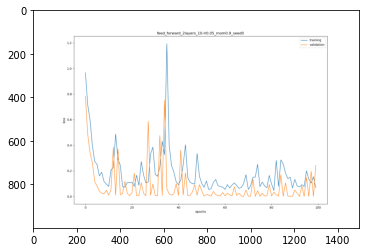

In [17]:
# 5 diagrams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('experiments/feed_forward_2layers_10-lr0.05_mom0.9_seed0/loss.png')
plt.imshow(img)
plt.show()